# 1- Explicando o problema de negócio


Um dos derivativos mais utilizados no mercado financeiro é a opção. Este derivativo dá a quem detém a opção de compra (venda) direito de comprar (vender) um ativo subjacente até a data de vencimento da opção.

A equação utilizada para precificar as opções foi derivada por Black e Scholes:
https://www.jstor.org/stable/1831029

A equação é a seguinte:





$C = S_tN(d_1) - Ke^{-rt}N(d_2)$

$d_1 = \frac{ln\frac{S_t}{k}+(r+\frac{(\sigma^2_v)}{2})t}{\sigma_s\sqrt{t}}$

$d_2 = d_1 - \sigma_s\sqrt{t}$

Onde:

C = Preço da opção de compra

S = Preço atual do ativo subjacente (se for opção de ação é o preço da ação, se for opção de câmbio á o preço à vista da moeda a ser comprada e assim por diante)

K = Preço de exercício da opção (strike)

r = Taxa de juros livre de risco

t = Tempo até o vencimento da opção

N = Distribuição normal

$\sigma_t$ = Desvio padrão anualizado dos retornos do ativo subjacente até a data do vencimento



Embora a primeira impressão seja que os traders no mercado usam essa fórmula para colocar o preço na opção, vemos que na prática o que acontece é uma "engenharia reversa".

O preço da opção é dado. Embora a fórmula possa servir de base, o preço observado é resultado da oferta e da demanda pela opção no mercado. Sendo assim, a variável que de fato interessa (que no momento da compra da opção não é observada de fato, mas uma ideia do que vai ser a volatilidade realizada até o vencimento da opção) é o $\sigma_t$, ou, a volatilidade implícita na opção. Ou seja, a rigor, a decisão de comprar ou não uma opção passa pela compração entre a volatilidade que está implícita no preço e a volatilidade que de fato vai ser obervada até o vencimento da opção.

Para que a decisão seja tomada, o trader precisa ter uma bao projeção da volatilidade do ativo. Se a volatilidade prevista for maior que a volatiidade implícita, significa que a opção está barata e o trader deve comprar a opção. No caso contrário, a volatilidade prevista é menor do que a volatilidade implícita, o trader deve vender opções.

Esta descrição faz uma série de simplificações das diversas nuances e de diversos fatores que afetem o preço de uma opção. Existe ainda um conjunto muito grande de diferentes estratégias que podem ser montadas com compra de opções de venda e de compra. No entanto, esses detalhes fogem do objetivo deste trabalho, que em resumo, é fazer uma boa previsão da volatilidade de ativos financeiros.

Acredite, ter uma boa previsão de volatilidade é importante!

Existem métodos estatísticos que são utilizados nesse tipo de projeção, os mais conhecimos são os modelos da família ARCH (Autoregressive Conditional Heteroskedasticity). https://www.jstor.org/stable/1912773

Neste trabalho, vamos tentar cumnprir o mesmo papel que estes modelos, se possível com resultados melhores.



# 2- Criação da base de dados e exploração dos dados

## 2.1- Instalação das bibliotecas

In [ ]:
#biblioteca necessária para importação dos dados
#!pip install yfinance

In [ ]:
#código para instalar a biblioteca TA-lib, utilizada para construção de indicadores de análise técnica
#url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
#!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
#url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
#!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

## 2.2 - Importação dos dados do yahoo finance e construção dos indicadores

In [2]:
import talib as ta
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%config Completer.use_jedi = True

In [3]:
symbols = ['PETR3.SA','VALE3.SA','BBDC3.SA','ITUB4.SA','BBAS3.SA','^BVSP','^VIX','BRL=X']

In [4]:
data = yf.download(tickers=symbols,start='2005-01-01',end='2023-05-31',auto_adjust=True)

[*********************100%***********************]  8 of 8 completed


In [5]:
data.dropna(inplace=True)

In [6]:
data.columns = data.columns.map('|'.join).str.strip('|')

In [7]:
data.head()

,Close|BBAS3.SA,Close|BBDC3.SA,Close|BRL=X,Close|ITUB4.SA,Close|PETR3.SA,Close|VALE3.SA,Close|^BVSP,Close|^VIX,High|BBAS3.SA,High|BBDC3.SA,...,Open|^BVSP,Open|^VIX,Volume|BBAS3.SA,Volume|BBDC3.SA,Volume|BRL=X,Volume|ITUB4.SA,Volume|PETR3.SA,Volume|VALE3.SA,Volume|^BVSP,Volume|^VIX
Date,,,,,,,,,,,,,,,,,,,,,
2006-03-24,7.430069,4.077613,2.1547,6.689701,7.940864,11.596475,37577.0,11.19,7.471429,4.077613,...,37473.0,11.23,921600.0,483596.0,0.0,5319514.0,1154600.0,7988800.0,0.0,0.0
2006-03-27,7.077848,4.005969,2.1503,6.501597,7.951132,11.870032,37641.0,11.46,7.311330,4.005969,...,37577.0,11.46,2470500.0,663921.0,0.0,8050536.0,1770400.0,11796800.0,0.0,0.0
2006-03-28,6.617554,3.853460,2.1677,6.366556,7.874105,11.953287,36682.0,11.58,7.076514,3.853460,...,37640.0,11.69,3059100.0,604496.0,0.0,15584100.0,2122800.0,7315200.0,0.0,0.0
2006-03-29,6.777657,3.886027,2.2206,6.346299,8.035012,12.226849,37492.0,10.95,6.817683,3.886027,...,36684.0,11.46,2291400.0,555316.0,0.0,13505334.0,2918400.0,7761600.0,0.0,0.0
2006-03-30,6.817684,3.826324,2.1922,6.315428,8.077808,12.595556,37777.0,11.57,6.897735,3.826324,...,37493.0,11.03,1389600.0,655724.0,0.0,11240554.0,949000.0,8323200.0,0.0,0.0


Vamos calcular alguns indicadores utilizados na análise tácnica de ações. Esses indicadores podem ser calculados considerando intervalos diferentes de tempo, no nosso caso, vamos utilizar janelas de 3, 5, 10, 15, 30, 45 e 60 dias.

---







In [8]:
horizons = [3,5,10,15,30,45,60]

O primeiro indicador que vai ser adicionado na base é o Relative Strength Index (RSI), este indicador é utilizado para dar uma ideia de qual deverá ser a tendência do preço do ativo no futuro. É possível que a volatilidade tenha comportamentos diferentes dependendo da direção dos retornos do ativo.

$RS = \frac{\mu_nAlta}{\mu_nBaixa}$

$RSI = 100 - \frac{100}{1 + RS} $

Onde:

$\mu_nAlta$ =  Média dos últimos n dias de alta

$\mu_nBaixa$ =  Média dos últimos n dias de baixa em valor absoluto


In [9]:
help(ta.RSI)

Help on function RSI in module talib._ta_lib:

RSI(...)
    RSI(real[, timeperiod=?])
    
    Relative Strength Index (Momentum Indicators)
    
    Inputs:
        real: (any ndarray)
    Parameters:
        timeperiod: 14
    Outputs:
        real



In [10]:
#indicador RSI

for ticker in symbols:
  for window in horizons:
    data['RSI_'+ticker+'_'+str(window)] = ta.RSI(data['Close|'+ticker],timeperiod=window)

In [11]:
data.tail()

,Close|BBAS3.SA,Close|BBDC3.SA,Close|BRL=X,Close|ITUB4.SA,Close|PETR3.SA,Close|VALE3.SA,Close|^BVSP,Close|^VIX,High|BBAS3.SA,High|BBDC3.SA,...,RSI_^VIX_30,RSI_^VIX_45,RSI_^VIX_60,RSI_BRL=X_3,RSI_BRL=X_5,RSI_BRL=X_10,RSI_BRL=X_15,RSI_BRL=X_30,RSI_BRL=X_45,RSI_BRL=X_60
Date,,,,,,,,,,,,,,,,,,,,,
2023-05-23,43.529362,13.548825,4.9661,26.292364,27.818466,66.559998,109929.0,18.530001,43.676157,13.814875,...,49.571563,48.752417,48.499675,52.789467,52.784139,48.545303,46.591279,45.564236,46.114261,46.732532
2023-05-24,43.656586,13.263068,4.9712,26.143932,28.120739,65.050003,108800.0,20.030001,44.018677,13.489703,...,52.353482,50.591482,49.852958,56.688584,54.822021,49.509018,47.216110,45.849731,46.288662,46.854726
2023-05-25,43.705517,13.489703,4.9586,26.965260,27.912926,64.849998,110054.0,19.139999,44.429703,13.578387,...,50.638833,49.513269,49.074856,43.403573,48.373942,47.087940,45.797785,45.243260,45.913179,46.586215
2023-05-26,43.451077,13.469995,5.0352,26.757456,28.375780,66.330002,110906.0,17.950001,44.351412,13.696630,...,48.444254,48.111139,48.055000,81.958808,72.739599,60.226241,54.667661,49.448505,48.510096,48.413902
2023-05-30,43.744663,13.213799,5.0181,26.262678,27.931818,64.279999,108967.0,17.459999,43.901244,13.548825,...,47.566162,47.544150,47.640422,66.735246,64.274478,56.732056,52.608478,48.586776,47.984080,48.040710


In [12]:
#medias móveis

for ticker in symbols:
  for window in horizons:
    data['MA'+'_'+str(window)+'_'+ticker] = ta.SMA(data['Close|'+ticker],timeperiod=window)

Outro indicador que pode nos auxiliar á o Average True Range (ATR). Este indicador é um importante sinal de volatilidade. É calculado com com base nos True Ranges observados em um intervalo de tempo. A fórmula de cálculo é conforme segue:

$ TR = Max [(D_{0}High - D_{-1}Close), (D_0Low - D_{-1}Close),(D_0High - D_0Low)]$

$ Prior ATR = \frac{\sum Max_n(TR)}{n} $

$ ATR = \frac{[Prior ATR*(n-1)+TR_0]}{n}$

Onde:

$D_0High =$ Preço máximo do dia

$D_0Low =$ Preço mínimo do dia

$D_{-1}Close=$ Preço de fechamento do dia anterior


$ \sum Max_n(TR) = $ Soma dos n maiores valores observados dividida por n







In [13]:
help(ta.ATR)

Help on function ATR in module talib._ta_lib:

ATR(...)
    ATR(high, low, close[, timeperiod=?])
    
    Average True Range (Volatility Indicators)
    
    Inputs:
        prices: ['high', 'low', 'close']
    Parameters:
        timeperiod: 14
    Outputs:
        real



In [14]:
#indicador ATR

for ticker in symbols:
  for window in horizons:
    data['ATR_'+str(window)+'_'+ticker] = ta.ATR(high = data['High|'+ticker],low = data['Low|'+ticker],close = data['Close|'+ticker],timeperiod=window)

In [15]:
#retornos diários
for ticker in symbols:
  data[ticker+'_return'] = data['Close|'+ticker].pct_change()

In [16]:
data.tail()

,Close|BBAS3.SA,Close|BBDC3.SA,Close|BRL=X,Close|ITUB4.SA,Close|PETR3.SA,Close|VALE3.SA,Close|^BVSP,Close|^VIX,High|BBAS3.SA,High|BBDC3.SA,...,ATR_45_BRL=X,ATR_60_BRL=X,PETR3.SA_return,VALE3.SA_return,BBDC3.SA_return,ITUB4.SA_return,BBAS3.SA_return,^BVSP_return,^VIX_return,BRL=X_return
Date,,,,,,,,,,,,,,,,,,,,,
2023-05-23,43.529362,13.548825,4.9661,26.292364,27.818466,66.559998,109929.0,18.530001,43.676157,13.814875,...,0.072739,0.076997,0.020797,-0.022614,0.006589,0.007967,0.023470,-0.002577,0.076700,-0.006144
2023-05-24,43.656586,13.263068,4.9712,26.143932,28.120739,65.050003,108800.0,20.030001,44.018677,13.489703,...,0.071998,0.076370,0.010866,-0.022686,-0.021091,-0.005645,0.002923,-0.010270,0.080950,0.001027
2023-05-25,43.705517,13.489703,4.9586,26.965260,27.912926,64.849998,110054.0,19.139999,44.429703,13.578387,...,0.072110,0.076381,-0.007390,-0.003075,0.017088,0.031416,0.001121,0.011526,-0.044433,-0.002535
2023-05-26,43.451077,13.469995,5.0352,26.757456,28.375780,66.330002,110906.0,17.950001,44.351412,13.696630,...,0.072223,0.076395,0.016582,0.022822,-0.001461,-0.007706,-0.005822,0.007742,-0.062173,0.015448
2023-05-30,43.744663,13.213799,5.0181,26.262678,27.931818,64.279999,108967.0,17.459999,43.901244,13.548825,...,0.072084,0.076221,-0.015646,-0.030906,-0.019020,-0.018491,0.006757,-0.017483,-0.027298,-0.003396


In [17]:
help(ta.STDDEV)

Help on function STDDEV in module talib._ta_lib:

STDDEV(...)
    STDDEV(real[, timeperiod=?, nbdev=?])
    
    Standard Deviation (Statistic Functions)
    
    Inputs:
        real: (any ndarray)
    Parameters:
        timeperiod: 5
        nbdev: 1
    Outputs:
        real



In [18]:
#volatilidade dos retornos
for ticker in symbols:
  for window in horizons:
    data['SD_'+str(window)+'_'+ticker] = ta.STDDEV(data[ticker +'_return'],timeperiod=window)



In [19]:
data.tail()

,Close|BBAS3.SA,Close|BBDC3.SA,Close|BRL=X,Close|ITUB4.SA,Close|PETR3.SA,Close|VALE3.SA,Close|^BVSP,Close|^VIX,High|BBAS3.SA,High|BBDC3.SA,...,SD_30_^VIX,SD_45_^VIX,SD_60_^VIX,SD_3_BRL=X,SD_5_BRL=X,SD_10_BRL=X,SD_15_BRL=X,SD_30_BRL=X,SD_45_BRL=X,SD_60_BRL=X
Date,,,,,,,,,,,,,,,,,,,,,
2023-05-23,43.529362,13.548825,4.9661,26.292364,27.818466,66.559998,109929.0,18.530001,43.676157,13.814875,...,0.059217,0.056578,0.063104,0.005727,0.005825,0.006015,0.006926,0.007932,0.007634,0.007605
2023-05-24,43.656586,13.263068,4.9712,26.143932,28.120739,65.050003,108800.0,20.030001,44.018677,13.489703,...,0.060693,0.055455,0.063878,0.005188,0.004525,0.005911,0.006365,0.007891,0.007505,0.007602
2023-05-25,43.705517,13.489703,4.9586,26.965260,27.912926,64.849998,110054.0,19.139999,44.429703,13.578387,...,0.061299,0.055294,0.063994,0.002927,0.004762,0.005302,0.006034,0.007883,0.007344,0.007369
2023-05-26,43.451077,13.469995,5.0352,26.757456,28.375780,66.330002,110906.0,17.950001,44.351412,13.696630,...,0.062371,0.053461,0.064478,0.007775,0.007556,0.006837,0.007186,0.008100,0.007679,0.007655
2023-05-30,43.744663,13.213799,5.0181,26.262678,27.931818,64.279999,108967.0,17.459999,43.901244,13.548825,...,0.061329,0.053171,0.064567,0.008687,0.007636,0.006940,0.007038,0.007447,0.007683,0.007601


Agora vamos adicionar um indicador de volume. O On Balance Volume (OBV) retorna um sinal apontando se o fluxo no mercado é de entrada (compra) no ativo ou de saída (venda) do ativo.

Se preço de fechamento hoje é maior que o fechamento do dia anterior:

$OBV = OBV_{anterior} + volume_{hoje}  $

Se preço de fechamento hoje é igual ao fechamento do dia anterior:

$OBV = OBV_{anterior} + 0  $

Se preço de fechamento hoje é menor que o fechamento do dia anterior:

$OBV = OBV_{anterior} - volume_{hoje}  $

In [20]:
help(ta.OBV)

Help on function OBV in module talib._ta_lib:

OBV(...)
    OBV(real, volume)
    
    On Balance Volume (Volume Indicators)
    
    Inputs:
        real: (any ndarray)
        prices: ['volume']
    Outputs:
        real



In [21]:
for ticker in symbols:
    data['OBV_'+ticker] = ta.OBV(real = data['Close|'+ticker],volume = data['Volume|'+ticker])

## 2.3- Exploração dos dados


Temos um dataset com informações de diversos ativos negociados em bolsa como as ações negociadas na B3, câmbio e o índice de volatilidade VIX. Além dos dados brutos, a base foi enriquecida com alguns dos indicadores mais utilizados em análise técnica, como o RSI e o ATR. Talvez não precisemos de toda essa informação nos modelos de machine learning, ou ainda, podemos nos valer de informações contidas nos dados pra pensarmos em novas variáveis.
Para chegarmos a alguma conclusão, vamos fazer a análise exploratória dos dados.


---










In [22]:
import matplotlib.pyplot as plt


In [23]:
data.describe()

,Close|BBAS3.SA,Close|BBDC3.SA,Close|BRL=X,Close|ITUB4.SA,Close|PETR3.SA,Close|VALE3.SA,Close|^BVSP,Close|^VIX,High|BBAS3.SA,High|BBDC3.SA,...,SD_45_BRL=X,SD_60_BRL=X,OBV_PETR3.SA,OBV_VALE3.SA,OBV_BBDC3.SA,OBV_ITUB4.SA,OBV_BBAS3.SA,OBV_^BVSP,OBV_^VIX,OBV_BRL=X
count,4112.000000,4112.000000,4112.000000,4112.000000,4112.000000,4112.000000,4112.000000,4112.000000,4112.000000,4112.000000,...,4067.000000,4052.000000,4.112000e+03,4.112000e+03,4.112000e+03,4.112000e+03,4.112000e+03,4.112000e+03,4112.0,4112.0
mean,18.471304,9.707328,3.078475,15.681335,10.397483,30.636633,70401.674854,19.948752,18.761179,9.837020,...,0.011072,0.011173,-1.366687e+09,-1.704580e+09,9.209029e+07,6.893177e+08,2.726368e+08,3.324055e+09,0.0,0.0
std,9.824639,4.881690,1.301300,7.977107,5.018400,21.157890,24250.912467,9.179610,9.951453,4.946963,...,0.004714,0.004502,3.796412e+08,4.234759e+08,9.235180e+07,5.227297e+08,2.339053e+08,7.595735e+08,0.0,0.0
min,4.566912,2.688908,1.533700,4.220252,2.359048,5.583507,29435.000000,9.140000,5.003191,2.823353,...,0.002859,0.003097,-2.151340e+09,-2.351863e+09,-4.070989e+08,-1.662916e+08,-5.360927e+08,-2.601746e+08,0.0,0.0
25%,11.402604,5.304730,1.972300,9.149631,6.912760,17.794983,52810.750000,13.740000,11.588582,5.358038,...,0.007938,0.008298,-1.701295e+09,-1.865480e+09,4.213689e+07,2.586675e+08,1.812700e+08,3.377743e+09,0.0,0.0
50%,13.721198,8.807724,2.549000,12.265861,9.327392,22.898293,62792.500000,17.570000,13.940638,8.939805,...,0.010422,0.010639,-1.313260e+09,-1.816234e+09,9.916058e+07,5.185476e+08,2.451874e+08,3.427837e+09,0.0,0.0
75%,25.649993,13.637918,3.929725,23.176787,12.568648,34.865097,87745.000000,23.219999,26.031454,13.861287,...,0.013153,0.013066,-1.226694e+09,-1.698222e+09,1.732558e+08,1.187233e+09,4.220890e+08,3.591574e+09,0.0,0.0
max,43.744663,22.640915,5.886400,33.529308,31.447765,95.894073,130776.000000,82.690002,44.429703,22.811726,...,0.039017,0.036290,2.160334e+08,4.515533e+08,2.397586e+08,2.102147e+09,1.044210e+09,4.085797e+09,0.0,0.0


O primeiro ponto de atenção é o fato de o indicador OBV ser igual a zero para o VIX e o Câmbio. Isso provavelmente ocorre porque a fonte de dados não tem o volume desses ativos. Vamos fazer um plot dos dados para confirmar isso.

In [24]:
obv_cols = [c for c in data.columns if c.startswith('OBV_')]

In [25]:
obv = data[obv_cols]

In [26]:
obv['OBV_^VIX'] = obv['OBV_^VIX'] +1000000000 #adicionamos um número para que as linhas não fiquem sobrepostas

<Axes: xlabel='Date'>

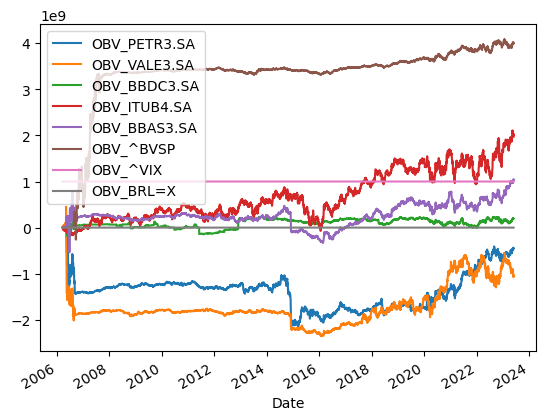

In [27]:
obv.plot()

Confirmamaos que o OBV do VIX e do câmbio estão zerados, vamor retirar essas variáveis da base.

In [28]:
data.drop(columns=['OBV_^VIX','OBV_BRL=X'],inplace=True)

In [29]:
data.describe()

,Close|BBAS3.SA,Close|BBDC3.SA,Close|BRL=X,Close|ITUB4.SA,Close|PETR3.SA,Close|VALE3.SA,Close|^BVSP,Close|^VIX,High|BBAS3.SA,High|BBDC3.SA,...,SD_15_BRL=X,SD_30_BRL=X,SD_45_BRL=X,SD_60_BRL=X,OBV_PETR3.SA,OBV_VALE3.SA,OBV_BBDC3.SA,OBV_ITUB4.SA,OBV_BBAS3.SA,OBV_^BVSP
count,4112.000000,4112.000000,4112.000000,4112.000000,4112.000000,4112.000000,4112.000000,4112.000000,4112.000000,4112.000000,...,4097.000000,4082.000000,4067.000000,4052.000000,4.112000e+03,4.112000e+03,4.112000e+03,4.112000e+03,4.112000e+03,4.112000e+03
mean,18.471304,9.707328,3.078475,15.681335,10.397483,30.636633,70401.674854,19.948752,18.761179,9.837020,...,0.010498,0.010914,0.011072,0.011173,-1.366687e+09,-1.704580e+09,9.209029e+07,6.893177e+08,2.726368e+08,3.324055e+09
std,9.824639,4.881690,1.301300,7.977107,5.018400,21.157890,24250.912467,9.179610,9.951453,4.946963,...,0.005495,0.005003,0.004714,0.004502,3.796412e+08,4.234759e+08,9.235180e+07,5.227297e+08,2.339053e+08,7.595735e+08
min,4.566912,2.688908,1.533700,4.220252,2.359048,5.583507,29435.000000,9.140000,5.003191,2.823353,...,0.001625,0.002492,0.002859,0.003097,-2.151340e+09,-2.351863e+09,-4.070989e+08,-1.662916e+08,-5.360927e+08,-2.601746e+08
25%,11.402604,5.304730,1.972300,9.149631,6.912760,17.794983,52810.750000,13.740000,11.588582,5.358038,...,0.006907,0.007612,0.007938,0.008298,-1.701295e+09,-1.865480e+09,4.213689e+07,2.586675e+08,1.812700e+08,3.377743e+09
50%,13.721198,8.807724,2.549000,12.265861,9.327392,22.898293,62792.500000,17.570000,13.940638,8.939805,...,0.009466,0.010128,0.010422,0.010639,-1.313260e+09,-1.816234e+09,9.916058e+07,5.185476e+08,2.451874e+08,3.427837e+09
75%,25.649993,13.637918,3.929725,23.176787,12.568648,34.865097,87745.000000,23.219999,26.031454,13.861287,...,0.012724,0.013129,0.013153,0.013066,-1.226694e+09,-1.698222e+09,1.732558e+08,1.187233e+09,4.220890e+08,3.591574e+09
max,43.744663,22.640915,5.886400,33.529308,31.447765,95.894073,130776.000000,82.690002,44.429703,22.811726,...,0.056366,0.043404,0.039017,0.036290,2.160334e+08,4.515533e+08,2.397586e+08,2.102147e+09,1.044210e+09,4.085797e+09


### 2.3.1 - Clusters de volatilidade

Para conseguirmos prever a volatilidade de um determinado ativo, podemos utilizar a volatilidade e os retornos passados do próprio ativo e de outros que com ele estejam correlacionados. Um dos fatos estilizados mais importantes sobre a volatilidade é que ela tende a ocorrer em clusters, ou seja, períodos de alta volatilidade tendem a ser seguidos por dias de alta volatilidade e períodos de baixa volatilidade tendem a ser seguidos por períodos de baixa volatilidade, até que algum evento eleve a volatilidade. Nos gráficos abaixo vamos tentar visualizar esses fenômenos.

---



In [30]:
return_cols = [c for c in data.columns if c.endswith('_return')]

In [31]:
returns = data[return_cols]

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

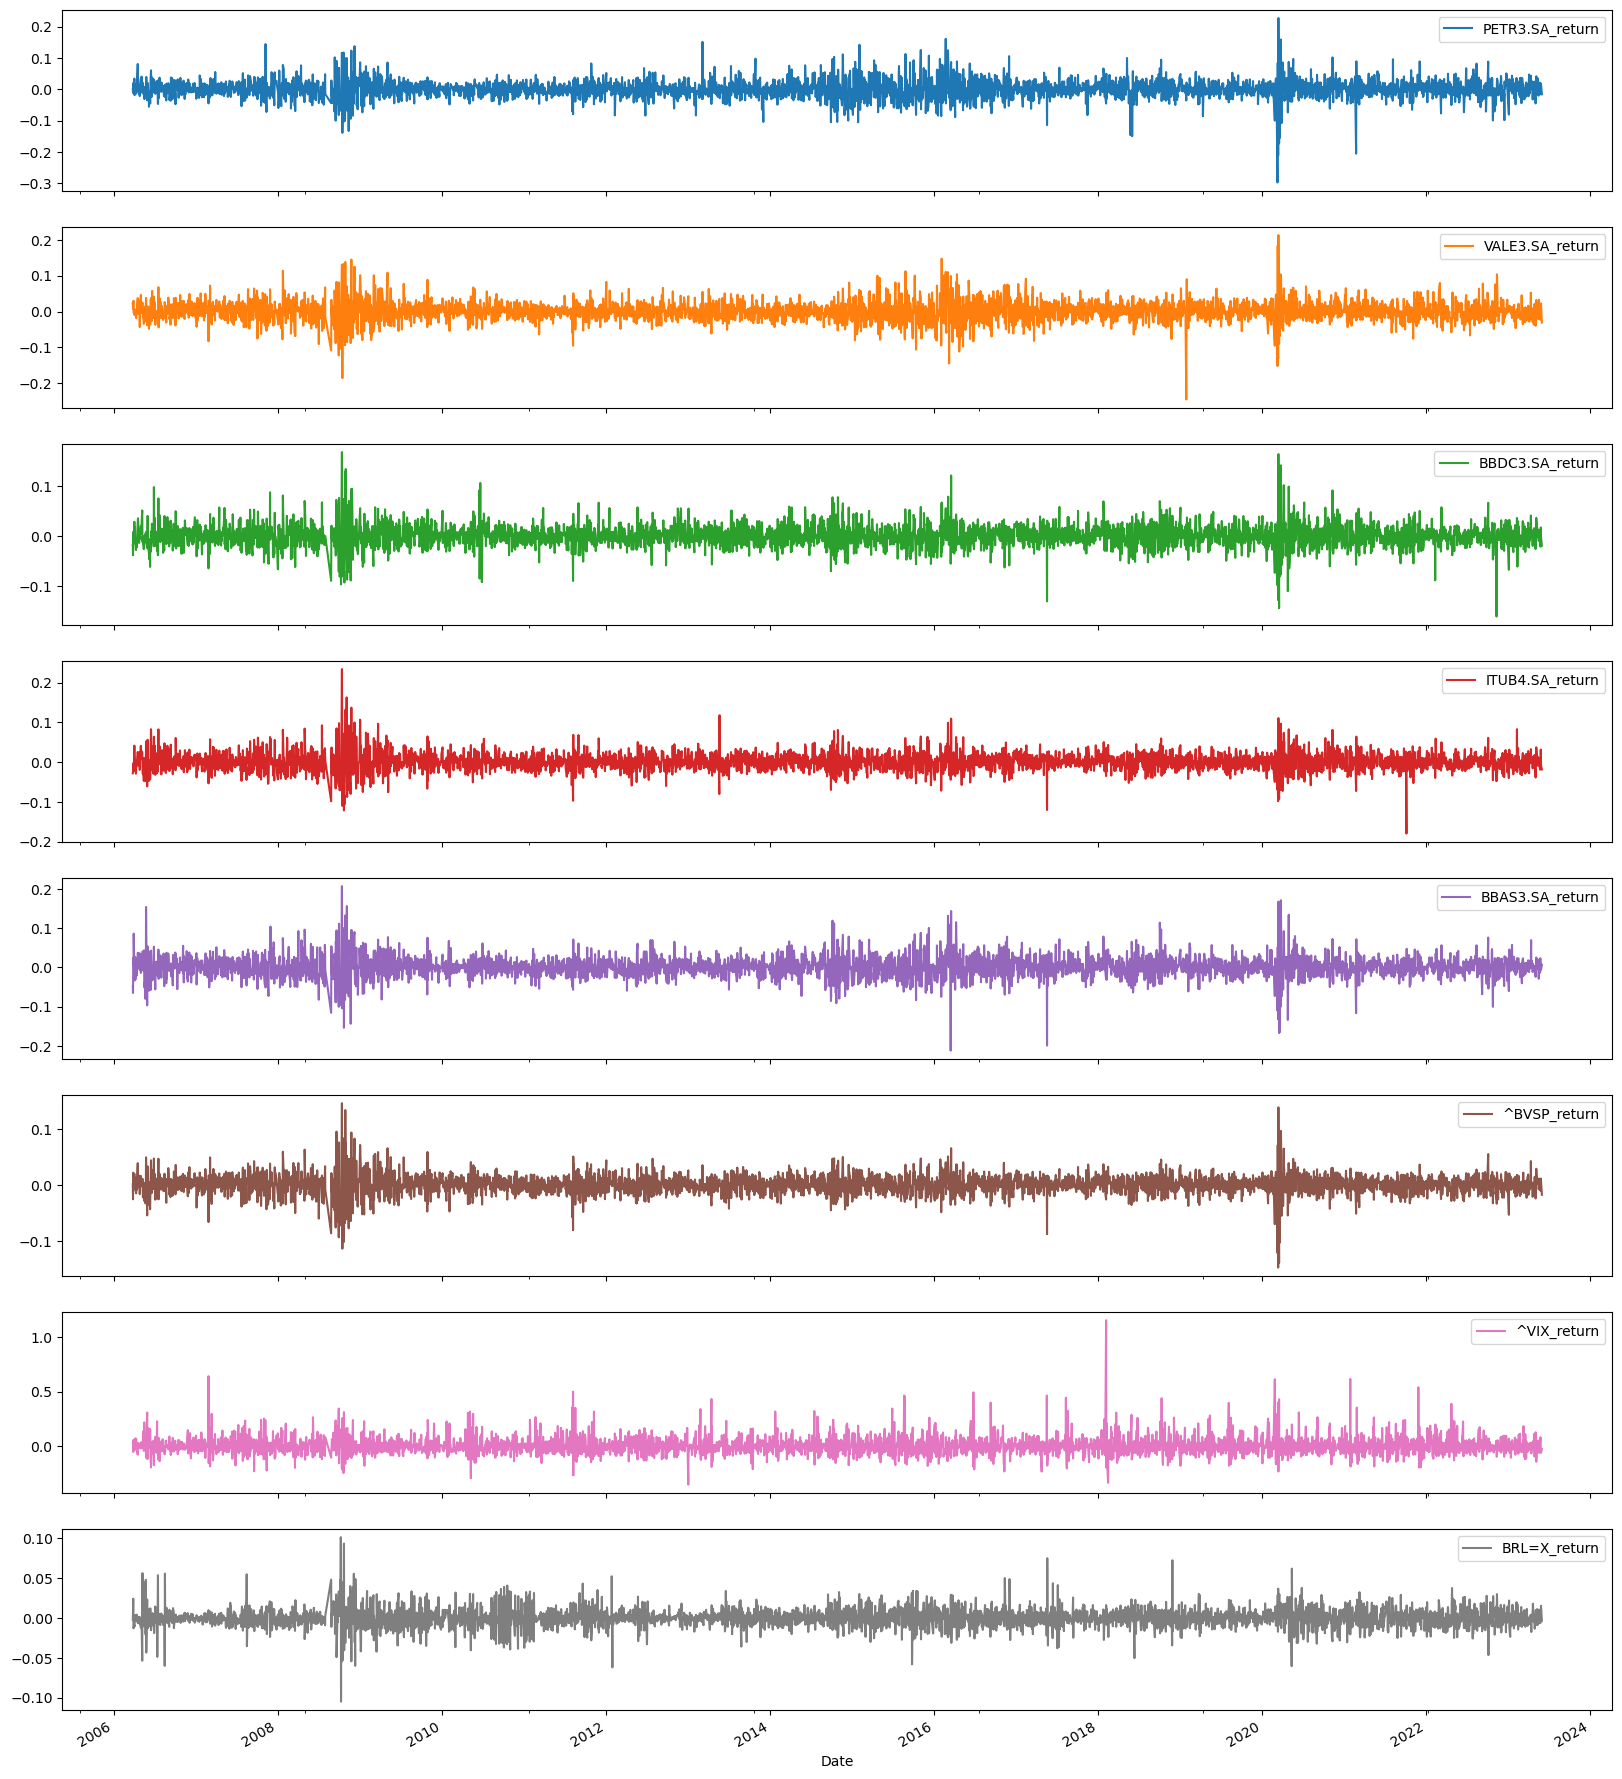

In [32]:
returns.plot(figsize = (20,25),subplots = True)

In [33]:
sd_60_cols = [c for c in data.columns if c.startswith('SD_60')]

In [34]:
volatility_60 = data[sd_60_cols]

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

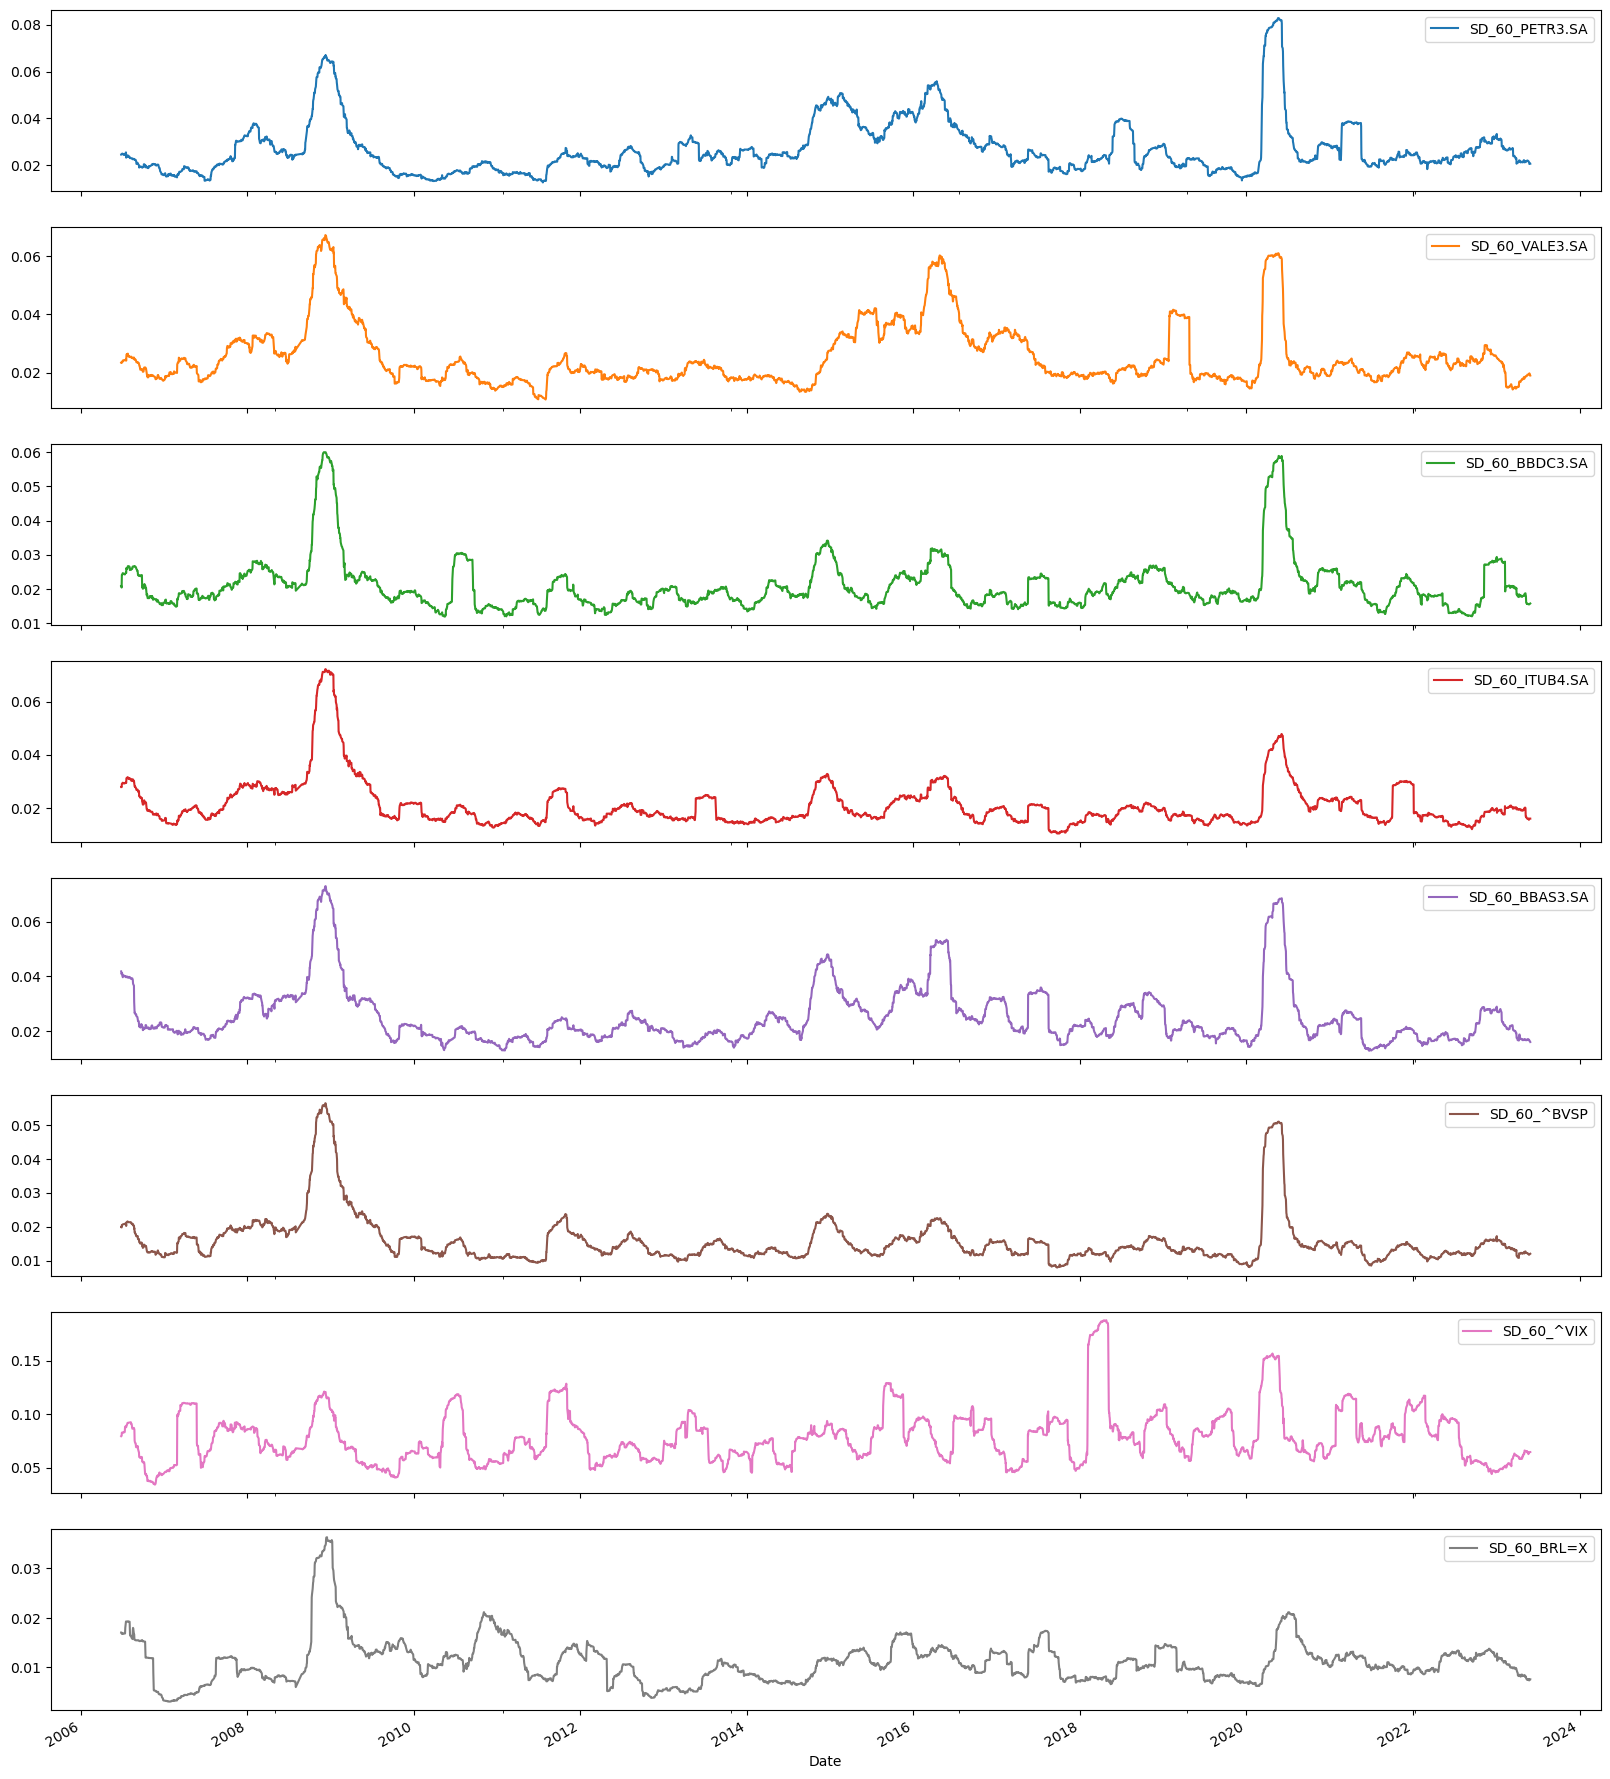

In [35]:
volatility_60.plot(figsize = (20,25),subplots = True)

In [36]:
sd_5_cols = [c for c in data.columns if c.startswith('SD_5')]

In [37]:
volatility_5 = data[sd_5_cols]

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

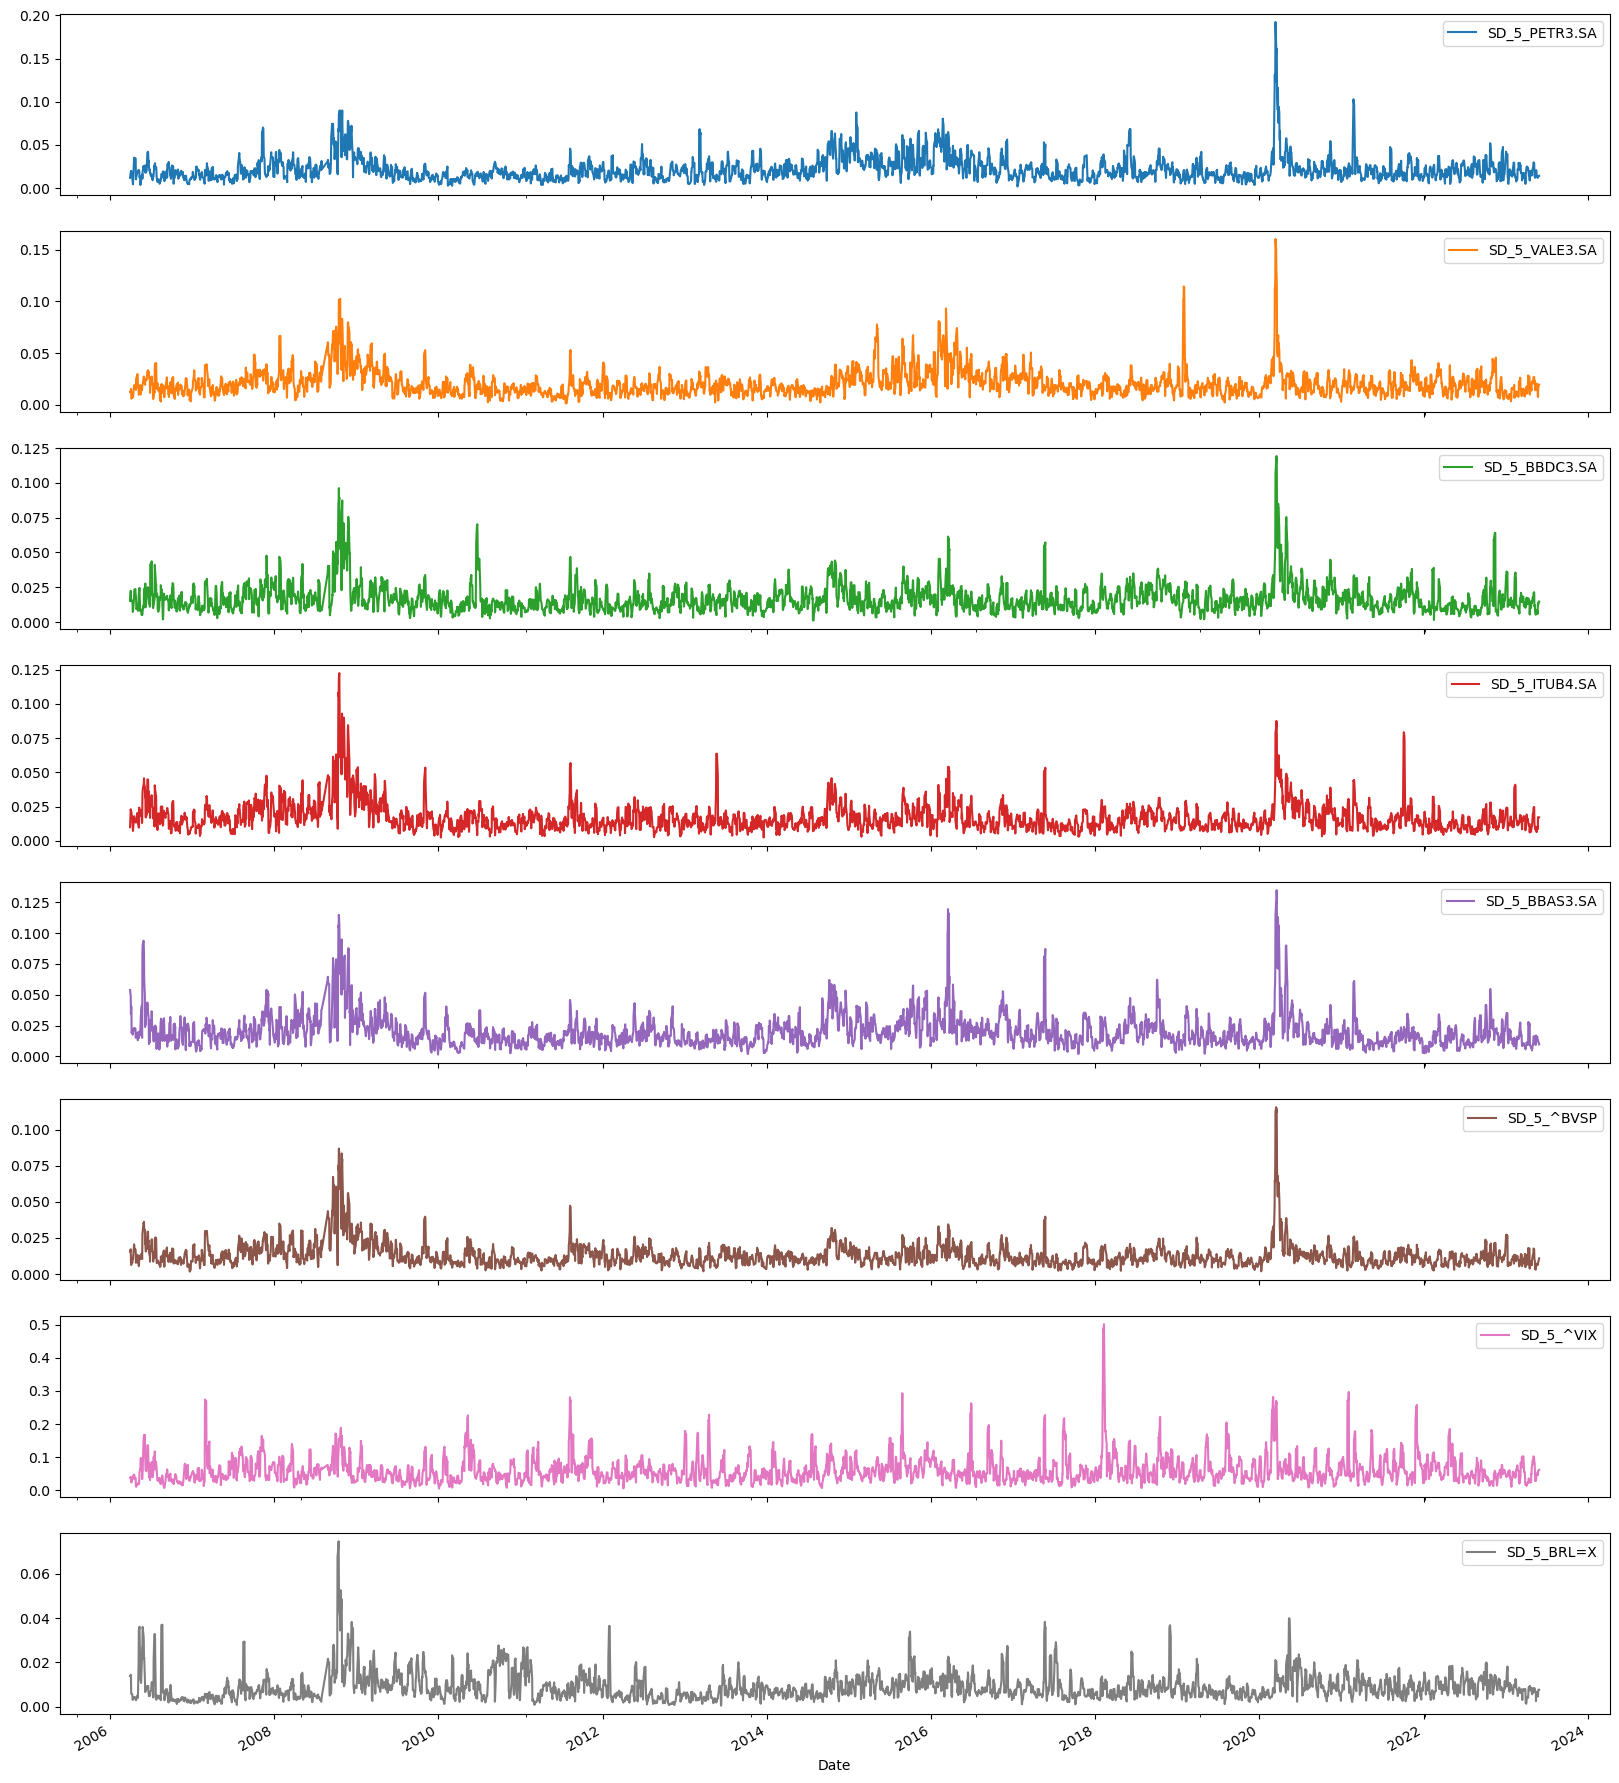

In [38]:
volatility_5.plot(figsize = (20,25),subplots = True)

Nos gráficos acima nós percebemos a formação dos clusters de volatilidade, e ainda mais, vemos que na dimensão cross section (ativos diferentes) os clusters possuem correlação, indicando que a volatilidade de uma determinada ação na bolsa pode ajudar a explicar a volatilidade de outras ações. Vamos explorar essas correlações entre os retornos dos ativos, suas volatilidades e a correlação com os indicadores que adicionamos na base.

### 2.3.2- Análise de correlações

Nosso foco será fazer a projeção da volatilidade no índice da B3 (^BVSP) nos próximos 60 dias. Vamos começar explorando como a volatilidade do índice se correlaciona com as variáveis que estão no dataset.

In [39]:
#como queremos fazer aprevisão, vamos deslocar a variável prevista 61 dias para trás,
#queremos prever qual será a volatilidade realizada nos próximos 60 dias

data['SD_60_FUTURE'] = data['SD_60_^BVSP'].shift(-61)
data.dropna(inplace = True)

In [40]:
corr_asc = data.corr()[['SD_60_FUTURE']].sort_values(by='SD_60_FUTURE', ascending=True).head(30)

In [41]:
corr_desc =  data.corr()[['SD_60_FUTURE']].sort_values(by='SD_60_FUTURE', ascending=False).head(30)

In [42]:
corr_asc

,SD_60_FUTURE
RSI_BBDC3.SA_60,-0.246976
RSI_BBDC3.SA_45,-0.238999
RSI_BBDC3.SA_30,-0.222593
RSI_ITUB4.SA_60,-0.218398
RSI_ITUB4.SA_45,-0.212364
RSI_VALE3.SA_60,-0.207425
RSI_VALE3.SA_45,-0.204172
RSI_ITUB4.SA_30,-0.201344
RSI_VALE3.SA_30,-0.192027
RSI_BBDC3.SA_15,-0.191168


In [43]:
corr_desc

,SD_60_FUTURE
SD_60_FUTURE,1.000000
SD_10_^BVSP,0.449068
SD_15_^BVSP,0.441266
SD_5_^BVSP,0.420631
SD_15_ITUB4.SA,0.413760
SD_10_ITUB4.SA,0.411605
SD_30_^BVSP,0.397180
SD_30_ITUB4.SA,0.384842
ATR_5_PETR3.SA,0.367726
SD_10_BBAS3.SA,0.367001


<Axes: >

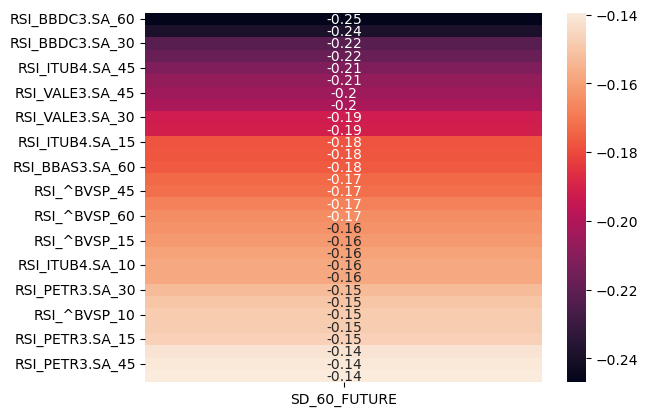

In [44]:
sns.heatmap(corr_asc, annot=True)

<Axes: >

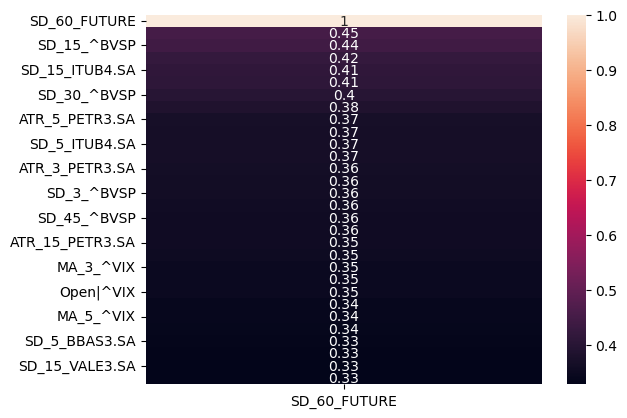

In [45]:
sns.heatmap(corr_desc, annot=True)

Vamos que a volatilidade na janela dos próximos 60 dias é correlacionada com a volatilidade passada, e com outras janelas de cálculo. Isso é um fato amplamento explorado em modelos tradicionais de projeção de volatilidade.
O ATR é um indicador de variação dos preços, não é surpresa que esteja positivamente correlacionado com a volatilidade futura. A média móvel (MA) também está positivamente correlacionada com a volatilidade, indicando que à medida que os preços seguem uma tendência de alta, a volatilidade tende a ser maior ("os preços sobem de escada,mas descem de elevador"). O RSI, indicador de força relativa, é negativamente correlacionado com a volatilidade, o que reforça a ideia anterior, já que um RSI alto (geralmente acima de 70) indica que o mercado está muito comprado, logo os preços tendem a cair e entrar numa fase de volatilidade menor. Um RSI baixo (30 ou menos) indica mercado excessivamente vendido, o que pode ser o gatilho para um rally de subida dos preços que por sua vez (lembre-se da média móvel) vem com maior volatilidade.

Embora seja uma boa notícia a correlação entre a nossa variável alvo e os preditores, nada é tão fácil assim.
Provavelmente, existe uma alta correlação entre os preditores, vamos verificar isso, e se for o caso,precisaremos selecionar os nossos preditores, de forma a reduvir ou até mesmo eliminar a correlação entre os preditores que de fato entram nos modelos.


In [46]:
ma_cols = [c for c in data.columns if c.startswith('MA')]

In [47]:
moving_averages = data[ma_cols]

In [48]:
moving_averages.corr()

,MA_3_PETR3.SA,MA_5_PETR3.SA,MA_10_PETR3.SA,MA_15_PETR3.SA,MA_30_PETR3.SA,MA_45_PETR3.SA,MA_60_PETR3.SA,MA_3_VALE3.SA,MA_5_VALE3.SA,MA_10_VALE3.SA,...,MA_30_^VIX,MA_45_^VIX,MA_60_^VIX,MA_3_BRL=X,MA_5_BRL=X,MA_10_BRL=X,MA_15_BRL=X,MA_30_BRL=X,MA_45_BRL=X,MA_60_BRL=X
MA_3_PETR3.SA,1.000000,0.999417,0.996500,0.993012,0.982819,0.972864,0.962787,0.672234,0.672466,0.672673,...,0.288720,0.310345,0.334612,0.257567,0.258453,0.260765,0.263110,0.270515,0.277725,0.284481
MA_5_PETR3.SA,0.999417,1.000000,0.998216,0.995147,0.985183,0.975360,0.965279,0.671411,0.671938,0.672395,...,0.288517,0.309692,0.333702,0.256406,0.257150,0.259336,0.261634,0.268994,0.276205,0.282995
MA_10_PETR3.SA,0.996500,0.998216,1.000000,0.998781,0.990365,0.981065,0.971149,0.669237,0.669968,0.671201,...,0.289005,0.308906,0.331989,0.253936,0.254461,0.256132,0.258191,0.265303,0.272475,0.279320
MA_15_PETR3.SA,0.993012,0.995147,0.998781,1.000000,0.994526,0.986039,0.976559,0.667186,0.667962,0.669475,...,0.290862,0.309228,0.331083,0.251684,0.252103,0.253424,0.255113,0.261775,0.268840,0.275688
MA_30_PETR3.SA,0.982819,0.985183,0.990365,0.994526,1.000000,0.996452,0.989533,0.661151,0.661935,0.663642,...,0.303727,0.315468,0.332795,0.245764,0.246020,0.246800,0.247792,0.252472,0.258660,0.265198
MA_45_PETR3.SA,0.972864,0.975360,0.981065,0.986039,0.996452,1.000000,0.997319,0.654682,0.655525,0.657398,...,0.323169,0.328315,0.340222,0.240209,0.240379,0.240911,0.241599,0.244958,0.249732,0.255492
MA_60_PETR3.SA,0.962787,0.965279,0.971149,0.976559,0.989533,0.997319,1.000000,0.648336,0.649134,0.650966,...,0.342675,0.345591,0.352510,0.235395,0.235504,0.235842,0.236289,0.238762,0.242423,0.247076
MA_3_VALE3.SA,0.672234,0.671411,0.669237,0.667186,0.661151,0.654682,0.648336,1.000000,0.999753,0.998643,...,0.118757,0.130648,0.143069,0.725308,0.726078,0.727938,0.729865,0.735902,0.741906,0.747532
MA_5_VALE3.SA,0.672466,0.671938,0.669968,0.667962,0.661935,0.655525,0.649134,0.999753,1.000000,0.999308,...,0.118090,0.129894,0.142288,0.724795,0.725519,0.727355,0.729248,0.735264,0.741269,0.746932
MA_10_VALE3.SA,0.672673,0.672395,0.671201,0.669475,0.663642,0.657398,0.650966,0.998643,0.999308,1.000000,...,0.116830,0.128360,0.140533,0.723708,0.724336,0.725998,0.727794,0.733692,0.739673,0.745406


In [49]:
atr_cols = [c for c in data.columns if c.startswith('ATR')]

In [50]:
atr = data[atr_cols]

In [51]:
atr.corr()

,ATR_3_PETR3.SA,ATR_5_PETR3.SA,ATR_10_PETR3.SA,ATR_15_PETR3.SA,ATR_30_PETR3.SA,ATR_45_PETR3.SA,ATR_60_PETR3.SA,ATR_3_VALE3.SA,ATR_5_VALE3.SA,ATR_10_VALE3.SA,...,ATR_30_^VIX,ATR_45_^VIX,ATR_60_^VIX,ATR_3_BRL=X,ATR_5_BRL=X,ATR_10_BRL=X,ATR_15_BRL=X,ATR_30_BRL=X,ATR_45_BRL=X,ATR_60_BRL=X
ATR_3_PETR3.SA,1.000000,0.989008,0.952893,0.926818,0.879795,0.851231,0.829380,0.642028,0.642700,0.633083,...,0.405616,0.404355,0.405164,0.376846,0.371856,0.351498,0.334081,0.299854,0.280114,0.267446
ATR_5_PETR3.SA,0.989008,1.000000,0.984723,0.965181,0.922152,0.893459,0.870958,0.656669,0.664437,0.660931,...,0.437319,0.434891,0.434686,0.392288,0.392528,0.375539,0.358068,0.321339,0.299427,0.285164
ATR_10_PETR3.SA,0.952893,0.984723,1.000000,0.995089,0.967320,0.942527,0.921271,0.654559,0.671407,0.680635,...,0.478644,0.477542,0.477125,0.406265,0.413925,0.405606,0.390914,0.353831,0.329325,0.312643
ATR_15_PETR3.SA,0.926818,0.965181,0.995089,1.000000,0.986302,0.966870,0.948189,0.643962,0.664421,0.681133,...,0.498339,0.501398,0.502688,0.413029,0.424345,0.422100,0.410554,0.375812,0.350474,0.332411
ATR_30_PETR3.SA,0.879795,0.922152,0.967320,0.986302,1.000000,0.994941,0.984813,0.614746,0.637896,0.663318,...,0.515828,0.533184,0.542540,0.421436,0.437487,0.445270,0.440817,0.415696,0.391967,0.372818
ATR_45_PETR3.SA,0.851231,0.893459,0.942527,0.966870,0.994941,1.000000,0.997099,0.592138,0.615352,0.643117,...,0.516277,0.544680,0.561642,0.423760,0.441713,0.454360,0.454204,0.437288,0.416895,0.398645
ATR_60_PETR3.SA,0.829380,0.870958,0.921271,0.948189,0.984813,0.997099,1.000000,0.573702,0.596541,0.624978,...,0.513367,0.549698,0.572834,0.424997,0.443965,0.459428,0.462023,0.451269,0.434148,0.417360
ATR_3_VALE3.SA,0.642028,0.656669,0.654559,0.643962,0.614746,0.592138,0.573702,1.000000,0.991324,0.962901,...,0.375520,0.383548,0.395575,0.528665,0.540131,0.541759,0.539809,0.541486,0.550415,0.561889
ATR_5_VALE3.SA,0.642700,0.664437,0.671407,0.664421,0.637896,0.615352,0.596541,0.991324,1.000000,0.988022,...,0.396013,0.404133,0.416022,0.540311,0.556464,0.562517,0.561659,0.563416,0.571984,0.583258
ATR_10_VALE3.SA,0.633083,0.660931,0.680635,0.681133,0.663318,0.643117,0.624978,0.962901,0.988022,1.000000,...,0.417544,0.428623,0.441514,0.547090,0.568857,0.583150,0.585829,0.590213,0.598753,0.609696


In [52]:
rsi_cols = [c for c in data.columns if c.startswith('RSI')]

In [53]:
rsi = data[rsi_cols]

In [54]:
rsi.corr()

,RSI_PETR3.SA_3,RSI_PETR3.SA_5,RSI_PETR3.SA_10,RSI_PETR3.SA_15,RSI_PETR3.SA_30,RSI_PETR3.SA_45,RSI_PETR3.SA_60,RSI_VALE3.SA_3,RSI_VALE3.SA_5,RSI_VALE3.SA_10,...,RSI_^VIX_30,RSI_^VIX_45,RSI_^VIX_60,RSI_BRL=X_3,RSI_BRL=X_5,RSI_BRL=X_10,RSI_BRL=X_15,RSI_BRL=X_30,RSI_BRL=X_45,RSI_BRL=X_60
RSI_PETR3.SA_3,1.000000,0.959183,0.816390,0.714232,0.546302,0.461299,0.407729,0.467717,0.460086,0.405068,...,-0.236689,-0.207340,-0.184711,-0.299410,-0.298587,-0.258533,-0.223861,-0.164166,-0.135944,-0.119552
RSI_PETR3.SA_5,0.959183,1.000000,0.934679,0.851435,0.682327,0.585744,0.521894,0.440693,0.465880,0.446209,...,-0.263029,-0.232838,-0.208530,-0.316898,-0.339011,-0.319929,-0.288867,-0.222538,-0.186530,-0.164190
RSI_PETR3.SA_10,0.816390,0.934679,1.000000,0.977993,0.860315,0.766218,0.696232,0.361783,0.417419,0.453782,...,-0.280079,-0.256445,-0.234396,-0.303029,-0.351384,-0.376494,-0.365851,-0.312401,-0.272975,-0.245297
RSI_PETR3.SA_15,0.714232,0.851435,0.977993,1.000000,0.941049,0.863854,0.798605,0.306403,0.369022,0.430705,...,-0.274890,-0.259359,-0.241287,-0.282502,-0.338617,-0.387829,-0.394208,-0.361815,-0.327358,-0.300295
RSI_PETR3.SA_30,0.546302,0.682327,0.860315,0.941049,1.000000,0.979516,0.942644,0.224391,0.286129,0.368772,...,-0.238650,-0.239479,-0.230682,-0.239587,-0.297526,-0.371298,-0.403529,-0.420333,-0.408300,-0.392250
RSI_PETR3.SA_45,0.461299,0.585744,0.766218,0.863854,0.979516,1.000000,0.989767,0.189109,0.246376,0.330613,...,-0.202718,-0.210974,-0.207172,-0.214303,-0.269528,-0.347560,-0.389106,-0.433595,-0.440091,-0.435942
RSI_PETR3.SA_60,0.407729,0.521894,0.696232,0.798605,0.942644,0.989767,1.000000,0.168122,0.220943,0.302603,...,-0.170594,-0.182442,-0.182089,-0.196376,-0.248572,-0.325807,-0.370769,-0.430641,-0.450488,-0.456251
RSI_VALE3.SA_3,0.467717,0.440693,0.361783,0.306403,0.224391,0.189109,0.168122,1.000000,0.959047,0.817495,...,-0.273420,-0.241755,-0.218301,-0.209678,-0.195092,-0.155922,-0.130336,-0.093385,-0.079760,-0.072857
RSI_VALE3.SA_5,0.460086,0.465880,0.417419,0.369022,0.286129,0.246376,0.220943,0.959047,1.000000,0.936180,...,-0.314439,-0.284732,-0.260212,-0.230096,-0.233141,-0.204548,-0.177637,-0.130497,-0.109306,-0.097293
RSI_VALE3.SA_10,0.405068,0.446209,0.453782,0.430705,0.368772,0.330613,0.302603,0.817495,0.936180,1.000000,...,-0.348762,-0.330203,-0.309458,-0.229820,-0.257519,-0.260638,-0.244191,-0.196787,-0.168077,-0.149307


Selecionamos os preditores mais correlacionados com a variável alvo e vimos que eles são muito correlacionados entre si, isso significa que tem muita informação "repetida" nos nossos preditores, o que pode dificultar o aprendizado dos algoritmos que serão utilizados.

In [124]:
#link alternativo para download dos dados caso não funcione a carga direta do yahoo finance

#data = pd.read_csv("https://raw.githubusercontent.com/Valpassos212/Copom_analisys/master/dados_volatilidade.csv")

# 3 - Teste de modelos de previsão

## 3.1 - Modelos com redução de dimensionalidade e mudança na escala dos dados

In [56]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error

Vamos fazer a divisão de dados de treino e de teste, lembrando que no nosso caso, a sequência dos dados é importante, não podemos fazer um split aleatório.

In [57]:
train_index = int(len(data)-100) #a proposta de uso é treinar o modelo todos os dias, para ter a projeção dos próximos 60 dias de volatilidade. 
train_index

3891

In [58]:
train_data = data.iloc[:train_index,:]
test_data = data.iloc[train_index:,:]

In [59]:
X_train = train_data.iloc[:,:-1]
y_train = train_data.iloc[:,-1:]

In [60]:
X_test = test_data.iloc[:,:-1]
y_test = test_data.iloc[:,-1:]

In [158]:
pipelines = [
    Pipeline([
        ("scaler",MinMaxScaler()), #MinMax scaler responde melhor a pequenas variações nas features do que o StandardScaler. Na projeção de volatilidade isso faz diferença.
        ("pca",PCA()),
        ("regressor",SVR())
    ]),
    Pipeline([
        ("polinomial",PolynomialFeatures()), # adicionei termos polinomiais mas o Ridge vai censurar o número de atributos
        ("regressor",Ridge())
    ]),
    Pipeline([
        ("polinomial",PolynomialFeatures()), # adicionei termos polinomiais mas o Lasso vai censurar o número de atributos
        ("regressor",Lasso())]),

    Pipeline([
        ("scaler",MinMaxScaler()),
    
        ("regressor",MLPRegressor())
    ])
]

In [159]:
param_grids = [
    {"regressor__kernel":['linear','poly','rbf','sigmoid'],
             "regressor__degree":[2,3],
             "regressor__C":[0.01,0.1,0.3,0.5,0.8,0.9],
              "pca__n_components":[0.5,0.75,0.8,0.9,0.95,1]
             },
    { "polinomial__degree":[2],
             "regressor__alpha":[0.01,0.1,0.3,0.5,0.8,0.9]              
             },
    {    "polinomial__degree":[2],
             "regressor__alpha":[0.01,0.1,0.3,0.5,0.8,0.9]
              
             },

    {"regressor__hidden_layer_sizes":[(100,),(150,),(200,),(250,),(300,)],
               "regressor__activation":["identity","logistic","tanh","relu"],
               "regressor__alpha":[0.001,0.010,0.0001,0.002],
               "regressor__learning_rate":["constant","adaptive"],
               "regressor__warm_start":[False,True]}
]

In [160]:
for i, pipeline in enumerate(pipelines):
    param_grid = param_grids[i]
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid,scoring='neg_mean_absolute_percentage_error')
    grid_search.fit(X_train, y_train)
    pred = grid_search.best_estimator_.predict(X_test)
    pct_error = mean_absolute_percentage_error(pred,y_test)

    # Print the best parameters and score for each pipeline
    print("Pipeline", i+1)
    print("Melhores parâmetros: ", grid_search.best_params_)
    print(f"Melhor métrica treino: {grid_search.best_score_*(-1):.2%}")
    print(f"Melhor métrica teste: {pct_error:.2%} ")

Pipeline 1
Melhores parâmetros:  {'pca__n_components': 0.5, 'regressor__C': 0.01, 'regressor__degree': 2, 'regressor__kernel': 'linear'}
Melhor métrica treino: 128.53%
Melhor métrica teste: 58.06% 
Pipeline 2
Melhores parâmetros:  {'polinomial__degree': 2, 'regressor__alpha': 0.01}
Melhor métrica treino: 2048.81%
Melhor métrica teste: 28.27% 
Pipeline 3
Melhores parâmetros:  {'polinomial__degree': 2, 'regressor__alpha': 0.9}
Melhor métrica treino: 135.53%
Melhor métrica teste: 47.13% 
Pipeline 4
Melhores parâmetros:  {'regressor__activation': 'logistic', 'regressor__alpha': 0.001, 'regressor__hidden_layer_sizes': (300,), 'regressor__learning_rate': 'adaptive', 'regressor__warm_start': True}
Melhor métrica treino: 45.76%
Melhor métrica teste: 39.31% 


Pipeline 1
Melhores parâmetros:  {'pca__n_components': 0.5, 'regressor__C': 0.01, 'regressor__degree': 2, 'regressor__kernel': 'linear'}
Melhor métrica treino: 128.53%
Melhor métrica teste: 58.06% 

Pipeline 2
Melhores parâmetros:  {'polinomial__degree': 2, 'regressor__alpha': 0.01}
Melhor métrica treino: 2048.81%
Melhor métrica teste: 28.27% 

Pipeline 3
Melhores parâmetros:  {'polinomial__degree': 2, 'regressor__alpha': 0.9}
Melhor métrica treino: 135.53%
Melhor métrica teste: 47.13% 

Pipeline 4
Melhores parâmetros:  {'regressor__activation': 'logistic', 'regressor__alpha': 0.001, 'regressor__hidden_layer_sizes': (300,), 'regressor__learning_rate': 'adaptive', 'regressor__warm_start': True}
Melhor métrica treino: 45.76%
Melhor métrica teste: 39.31%

## 3.2 - Random Forest

In [61]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate

In [62]:
# listas para hiperparametros
n_estimators = [200,300,400]
#max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
min_samples_split = [2, 4, 8]
min_samples_leaf = [2,4,8]


In [63]:
random_grid_rf = {'n_estimators': n_estimators,               
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
               }

In [64]:
rf = RandomForestRegressor()

In [70]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid_rf,
                               scoring='neg_mean_absolute_percentage_error')

In [71]:
rf_random.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestRegressor(),
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, None],
                                        'min_samples_leaf': [2, 4, 8],
                                        'min_samples_split': [2, 4, 8],
                                        'n_estimators': [200, 300, 400]},
                   scoring='neg_mean_absolute_percentage_error')

In [72]:
rf_random.best_score_*(-1)

0.36305039546907325

In [73]:
rf_random.best_estimator_

RandomForestRegressor(max_depth=20, min_samples_leaf=8, min_samples_split=4,
                      n_estimators=200)

In [76]:
#melhor estimador random forest (deixei registrado, pois o tempo necessário pra fazer o search é muito grande, quando não faço a redução de dimensionalidade)

best_rf = RandomForestRegressor(max_depth=20,min_samples_leaf=8,min_samples_split=4,n_estimators=200)

In [78]:
best_rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=8, min_samples_split=4,
                      n_estimators=200)

In [79]:
predictions_rf = best_rf.predict(X_test)

In [80]:
pct_error = mean_absolute_percentage_error(y_test,predictions_rf)

print(
        f"Erro absoluto percentual médio do teste é: {pct_error:.2%}"
        
    )

Erro absoluto percentual médio do teste é: 24.62%


Vemos que o resultado no teste é melhor do que o resultado no treino. Isso pode ser causado pelo fato de não termos tentado mais configurações de hiperparãmetros durante o treinamento do modelo. Testar mais combinações levaria a um tempo de computação muito maior, e por isso, nesse momento, achei melhor ficar apenas com os modelos mais simples. Ainda assim, o resultado é melhor do que aqueles dos modelos onde a dimensionalidade dos dados foi reduzida. A volatilidade pode responder a pequenas variações nas variáveis explicativas, por isso, mesmo que a redução de dimensionalidade perca pouca informação, essa perda já pode ser sufuciente para reduzir a capacidade preditiva do modelo.

O resultado do modelo é ruim. Além de não termos feito uma seleção mais criteriosa dos atributos, devemos lembrar que estamos trabalhando com um problema de série de tempo, onde o que realmente interessa é prever a próxima janela de 60 dias para a volatilidade. Não faz sentido treinar um modelo com dados passados e fazer a previsão nos próximos 100 dias. Vamos tentar fazer um cross validation onde prevemos apenas a próxima janela de 60 dias (nosso conjunto de teste em cada fold terá apenas uma observação).

In [106]:
#vamos fazer a validação cruzada considerando que sempre queremos prever a volatilidade realizada nos próximos 30 dias
#lembrando que o split do dado deve obedecer a dimensão tempo, não pode ser um split aleatório

ts_cv = TimeSeriesSplit(n_splits = 300,
max_train_size = 1000,
test_size = 1)

In [107]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1:]

In [108]:
for i, (train_index, test_index) in enumerate(ts_cv.split(X)):
...     print(f"Fold {i}:")
...     print(f"  Train: index={train_index}")
...     print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[2691 2692 2693 2694 2695 2696 2697 2698 2699 2700 2701 2702 2703 2704
 2705 2706 2707 2708 2709 2710 2711 2712 2713 2714 2715 2716 2717 2718
 2719 2720 2721 2722 2723 2724 2725 2726 2727 2728 2729 2730 2731 2732
 2733 2734 2735 2736 2737 2738 2739 2740 2741 2742 2743 2744 2745 2746
 2747 2748 2749 2750 2751 2752 2753 2754 2755 2756 2757 2758 2759 2760
 2761 2762 2763 2764 2765 2766 2767 2768 2769 2770 2771 2772 2773 2774
 2775 2776 2777 2778 2779 2780 2781 2782 2783 2784 2785 2786 2787 2788
 2789 2790 2791 2792 2793 2794 2795 2796 2797 2798 2799 2800 2801 2802
 2803 2804 2805 2806 2807 2808 2809 2810 2811 2812 2813 2814 2815 2816
 2817 2818 2819 2820 2821 2822 2823 2824 2825 2826 2827 2828 2829 2830
 2831 2832 2833 2834 2835 2836 2837 2838 2839 2840 2841 2842 2843 2844
 2845 2846 2847 2848 2849 2850 2851 2852 2853 2854 2855 2856 2857 2858
 2859 2860 2861 2862 2863 2864 2865 2866 2867 2868 2869 2870 2871 2872
 2873 2874 2875 2876 2877 2878 2879 2880 2881 2882 288

In [109]:
#o tempo de execução da validação cruzada é grande (960 min aprox). Optei por usar todos os dados, sem selecionar variáveis, pois a volatilidade pode responder
#pontualmente a uma determinada feature, e vimos que reduzindo o número de variáveis o resultado da previsão não foi tão bom.


cv_results = cross_validate(
        best_rf,
        X,
        y,
        cv=ts_cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error","neg_mean_absolute_percentage_error"],n_jobs=-1
    )

In [110]:
cross_val_pct_error = (cv_results["test_neg_mean_absolute_percentage_error"]*-1).mean()
cross_val_pct_error_std = (cv_results["test_neg_mean_absolute_percentage_error"]*-1).std()

print(f"O erro percentual médio é: {cross_val_pct_error:.2%}")

print(f"O desvio padrao do erro percentual é: {cross_val_pct_error_std:.2%}")


O erro percentual médio é: 2.69%
O desvio padrao do erro percentual é: 2.36%


Vimos que o erro percentual médio nos dados de teste é de aproximadamente 3% com desvio padrão de 3.5%. Isso nos leva a crer que os modelos baseados em árvores de decisão podem ser mais promissores.
Vamos tentar melhorar esse resultado usando técnicas de boosting ao invés do bagging que usamos no Random Forest.

## 3.3 - Gradient Boosting

In [111]:
from sklearn.ensemble import GradientBoostingRegressor

In [112]:
# listas para hiperparametros
learning_rate = [0.01,0.1,0.3,0.5,0.7]
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 500, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [2,4,8]

In [113]:
random_grid_gb = {'n_estimators': n_estimators,
                  'learning_rate':learning_rate,               
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
               }

In [114]:
gb_reg = GradientBoostingRegressor()

In [116]:
gb_reg_random = RandomizedSearchCV(estimator = gb_reg,  param_distributions= random_grid_gb, n_iter = 10,  verbose=2, random_state=11, n_jobs = -1)

In [117]:
gb_reg_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=GradientBoostingRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.3, 0.5,
                                                          0.7],
                                        'max_depth': [10, 20, 30, 40, 50, None],
                                        'min_samples_leaf': [2, 4, 8],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 233, 266, 300,
                                                         333, 366, 400, 433,
                                                         466, 500]},
                   random_state=11, verbose=2)

In [118]:
gb_reg_random.best_score_*(-1)

3.177989111393157

In [119]:
predictions_gb = gb_reg_random.predict(X_test)

In [120]:
pct_error_gb = mean_absolute_percentage_error(y_test,predictions_gb)

print(
    
        f"Erro absoluto percentual médio é: {pct_error_gb:.2%}"
        
    )

Erro absoluto percentual médio é: 26.64%


O resultado inicial do modelo já parece ser promissor, quando comparamos com o erro percentual médio do Random Forest (18%). Mas precisamos testar como fica esse resultado quando fazemos aquilo que é o verdadeiro uso do modelo, prever apenas a próxima janela de 60 dias de volatilidade.

In [121]:
gb_reg_random.best_estimator_

GradientBoostingRegressor(learning_rate=0.3, max_depth=10, min_samples_leaf=2,
                          min_samples_split=10, n_estimators=333)

In [122]:
#aproximadamente 800 minutos para rodar esse teste

cv_results = cross_validate(
        gb_reg_random.best_estimator_,
        X,
        y,
        cv=ts_cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error","neg_mean_absolute_percentage_error"]
    )

In [123]:
cross_val_pct_error_gb = (cv_results["test_neg_mean_absolute_percentage_error"]*-1).mean()
cross_val_pct_error_std_gb = (cv_results["test_neg_mean_absolute_percentage_error"]*-1).std()

print(f"O erro percentual médio é: {cross_val_pct_error_gb:.2%}")

print(f"O desvio padrao do erro percentual é: {cross_val_pct_error_std_gb:.2%}")

O erro percentual médio é: 2.50%
O desvio padrao do erro percentual é: 3.55%


Apesar de termos um erro ligeiramente menor no Gradiente Boosting, a variação no erro é maior doque aquela obtida com o Random forrest, sendo assim, a melhor escolha seria o Random Forest, que teve erro percentual médio de 2.69% com desvio padrão de 2.36%. Esse erro foi obtido com o cross validation testando em 300 datas diferentes. o que representa mais de 1 ano de negociação dos ativos em bolsa.

Não é possível descartar o uso de outros algoritmos e outras configurações do dataset, com seleção de variáveis e teste de hiperparâmetros diferentes, mas no momento, o tempo de computação seria muito grande e inviabilizaria o trabalho.